# Heart Disease Risk Prediction

In [ ]:
%pip install numpy matplotlib pandas seaborn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Load and prepare the dataset

In [3]:
df = pd.read_csv("Heart_Disease_Prediction.csv")

In [4]:
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


Check for missing values

In [ ]:
missing_values = df.isnull()
print(missing_values)

Remove rows with missing values

In [6]:
df_cleaned = df.dropna()

Summary statistics

In [7]:
print(df_cleaned.describe())

              Age         Sex  Chest pain type          BP  Cholesterol  \
count  270.000000  270.000000       270.000000  270.000000   270.000000   
mean    54.433333    0.677778         3.174074  131.344444   249.659259   
std      9.109067    0.468195         0.950090   17.861608    51.686237   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     48.000000    0.000000         3.000000  120.000000   213.000000   
50%     55.000000    1.000000         3.000000  130.000000   245.000000   
75%     61.000000    1.000000         4.000000  140.000000   280.000000   
max     77.000000    1.000000         4.000000  200.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    270.000000   270.000000  270.000000       270.000000      270.00000   
mean       0.148148     1.022222  149.677778         0.329630        1.05000   
std        0.355906     0.997891   23.165717         0.470952        1.14521   
min 

Convert target to binary and drop original

In [8]:
df_cleaned['Heart_Disease'] = df_cleaned['Heart Disease'].map({'Presence': 1, 'Absence': 0})
df_cleaned.drop(['Heart Disease'], axis=1, inplace=True)

Plot class distribution of Heart Disease by Sex

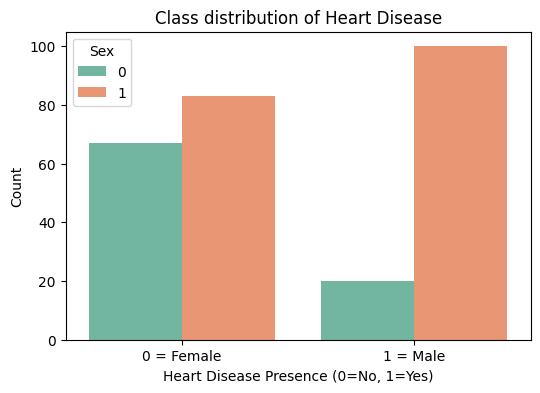

In [68]:
plt.figure(figsize=(6,4))
sns.countplot(x='Heart_Disease', hue='Sex', data=df_cleaned, palette='Set2')
plt.title('Class distribution of Heart Disease')
plt.xlabel('Heart Disease Presence (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks([0, 1], ['0 = Female', '1 = Male'])
plt.show()

Print dimensions of dataframe

In [10]:
print(f"Dataset shape: {df_cleaned.shape[0]} rows, {df_cleaned.shape[1]} columns")

Dataset shape: 270 rows, 14 columns


Split data into train (70%) and test sets

In [22]:
p_train = 0.70 # Training percentage
np.random.seed(42)
df_cleaned['is_train'] = np.random.uniform(0, 1, len(df_cleaned)) <= p_train
train, test = df_cleaned[df_cleaned['is_train']==True], df_cleaned[df_cleaned['is_train']==False]

Remove temporary split column

In [23]:
df_cleaned.drop(['is_train'], axis=1, inplace=True)
train.drop(['is_train'], axis=1, inplace=True)
test.drop(['is_train'], axis=1, inplace=True)

print(f"Training samples: {len(train)}")
print(f"Test samples:    {len(test)}")

Training samples: 189
Test samples:    81


Correlation heatmap of dataset features

<Axes: >

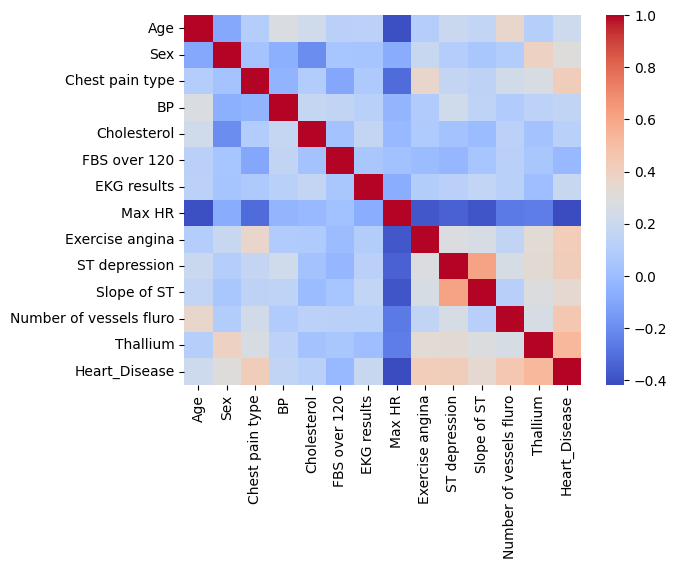

In [24]:
corr = df_cleaned.corr()
sns.heatmap(corr, cmap='coolwarm')


Select key features for classification model

In [ ]:
features = [
    "Chest pain type",
    "Max HR",
    "Exercise angina",
    "ST depression",
    "Slope of ST",
    "Number of vessels fluro",
    "Thallium"
]

X = train[features]
y = train["Heart_Disease"]

In [57]:
X = train[features].values
y = train["Heart_Disease"].values

x_test = test[features].values
y_test = test["Heart_Disease"].values

# Normalize
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / X_std        
x_test = (x_test - X_mean) / X_std

## Implement basic logistic regression

In [58]:
# Train set with the previously selected and normalized features
X_linear = X
y_linear = y

In [59]:
# Test set with the previously selected and normalized features
X_test = x_test
y_test = y_test

Sigmoid function

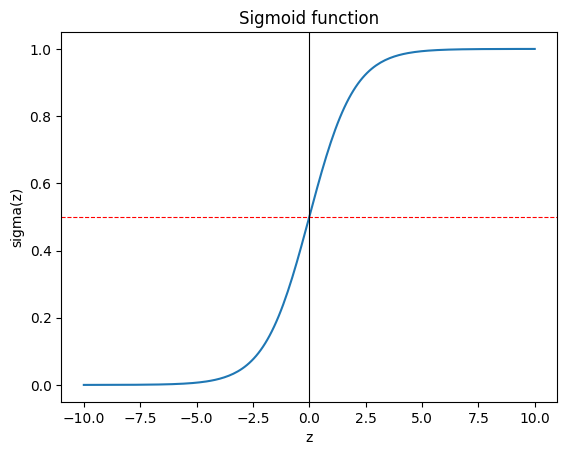

In [46]:
def sigmoid(z):
    """Compute the sigmoid of z."""
    return 1 / (1 + np.exp(-z))

# Visualize the sigmoid function
z_values = np.linspace(-10, 10, 200)
sig_values = sigmoid(z_values)

plt.figure()
plt.plot(z_values, sig_values)
plt.title("Sigmoid function")
plt.xlabel("z")
plt.ylabel("sigma(z)")
plt.ylim(-0.05, 1.05)
plt.axhline(0.5, color="red", linestyle="--", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)
plt.show()

Cost

In [61]:
def compute_cost(w, b, X, y):
    """Compute logistic regression cost J(w, b) using explicit model."""
    m, n = X.shape

    # For each example i: f_{w,b}^{(i)}(x^{(i)}) = sigmoid(w^T x^{(i)} + b)
    z = X @ w + b
    f = sigmoid(z)

    # To avoid log(0), clip probabilities
    eps = 1e-8
    f_clipped = np.clip(f, eps, 1 - eps)

    J = -(1 / m) * np.sum(
        y * np.log(f_clipped) + (1 - y) * np.log(1 - f_clipped)
    )
    return J

Gradient descent

In [62]:
def compute_gradient(w, b, X, y):
    """Compute gradients dJ/dw and dJ/db with explicit model."""
    m, n = X.shape

    # f_{w,b}^{(i)}(x^{(i)})
    z = X @ w + b
    f = sigmoid(z)

    error = f - y  # e^{(i)} = f_{w,b}^{(i)}(x^{(i)}) - y^{(i)}

    dj_dw = (1 / m) * (X.T @ error)
    dj_db = (1 / m) * np.sum(error)

    return dj_dw, dj_db

In [65]:
def gradient_descent(X, y, w_init, b_init, alpha, num_iters, print_every=0):
    """Run gradient descent to optimize w and b."""
    w = w_init.copy()
    b = b_init
    J_history = []

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(w, b, X, y)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        J = compute_cost(w, b, X, y)
        J_history.append(J)

        if print_every > 0 and (i % print_every == 0 or i == num_iters - 1):
            print(f"Iteration {i:4d}: J(w, b) = {J:.4f}")

    return w, b, J_history

# Train on the linear dataset
m_lin, n_lin = X_linear.shape
w0 = np.zeros(n_lin)
b0 = 0.0

alpha = 0.01
num_iters = 1000

w_trained, b_trained, J_hist = gradient_descent(
    X_linear, y_linear, w0, b0, alpha, num_iters, print_every=100
)

w_trained, b_trained

Iteration    0: J(w, b) = 0.6900
Iteration  100: J(w, b) = 0.5095
Iteration  200: J(w, b) = 0.4447
Iteration  300: J(w, b) = 0.4143
Iteration  400: J(w, b) = 0.3976
Iteration  500: J(w, b) = 0.3874
Iteration  600: J(w, b) = 0.3807
Iteration  700: J(w, b) = 0.3761
Iteration  800: J(w, b) = 0.3729
Iteration  900: J(w, b) = 0.3705
Iteration  999: J(w, b) = 0.3687


(array([ 0.42083206, -0.43212099,  0.48744331,  0.44988634,  0.20856739,
         0.66385003,  0.67363753]),
 np.float64(-0.3265029940347635))

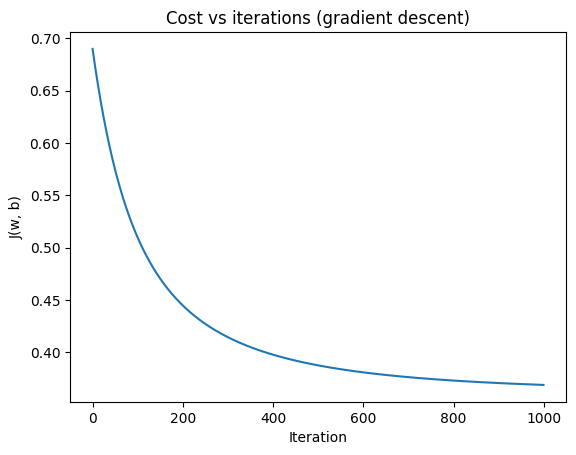

In [66]:
plt.figure()
plt.plot(J_hist)
plt.title("Cost vs iterations (gradient descent)")
plt.xlabel("Iteration")
plt.ylabel("J(w, b)")
plt.show()

Metrics

In [67]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0

y_train_pred = (sigmoid(X @ w_trained + b_trained) >= 0.5).astype(int)
y_test_pred = (sigmoid(X_test @ w_trained + b_trained) >= 0.5).astype(int)

print("TRAIN:")
print(f"Accuracy:  {accuracy(y, y_train_pred):.4f}")
print(f"Precision: {precision(y, y_train_pred):.4f}")
print(f"Recall:    {recall(y, y_train_pred):.4f}")
print(f"F1:        {f1(y, y_train_pred):.4f}")

print("\nTEST:")
print(f"Accuracy:  {accuracy(y_test, y_test_pred):.4f}")
print(f"Precision: {precision(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall(y_test, y_test_pred):.4f}")
print(f"F1:        {f1(y_test, y_test_pred):.4f}")

TRAIN:
Accuracy:  0.8783
Precision: 0.8784
Recall:    0.8228
F1:        0.8497

TEST:
Accuracy:  0.8272
Precision: 0.8857
Recall:    0.7561
F1:        0.8158


The model exhibits excellent convergence with cost dropping steadily from 0.69 to 0.37 over 1000 iterations, confirming proper normalization and stable gradient descent. Strong performance (88% train - 83% test accuracy) shows good generalization with conservative predictions favoring precision over recall—ideal for medical screening. Thallium and vessels emerge as strongest predictors.

## Visualize decision boundaries

In [104]:
feature_pairs = [
    ("Age", "Cholesterol"),              
    ("Age", "Max HR"),                   
    ("Age", "ST depression"),           
    ("BP", "Cholesterol"),           
    ("BP", "Max HR"),         
    ("Cholesterol", "Max HR"),
    ("Max HR", "ST depression")
]

In [105]:
def plot_linear_data_with_boundary(w, b, X, y, title, feat1="x1", feat2="x2"):
    """Plot 2D data (X, y) and a linear decision boundary defined by w, b."""
    plt.figure()
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker="o", label="y = 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker="x", label="y = 1")

    # Decision boundary: w0*x1 + w1*x2 + b = 0  => x2 = -(w0*x1 + b) / w1
    x1_vals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    if abs(w[1]) > 1e-6:
        x2_vals = -(w[0] * x1_vals + b) / w[1]
        plt.plot(x1_vals, x2_vals, "k--", label="decision boundary")
    else:
        x1_line = -b / w[0]
        plt.axvline(x1_line, color="k", linestyle="--", label="decision boundary")

    plt.title(title)
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.legend()
    plt.show()

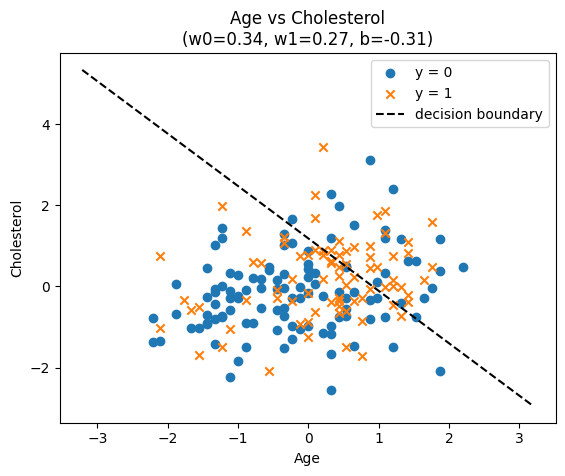

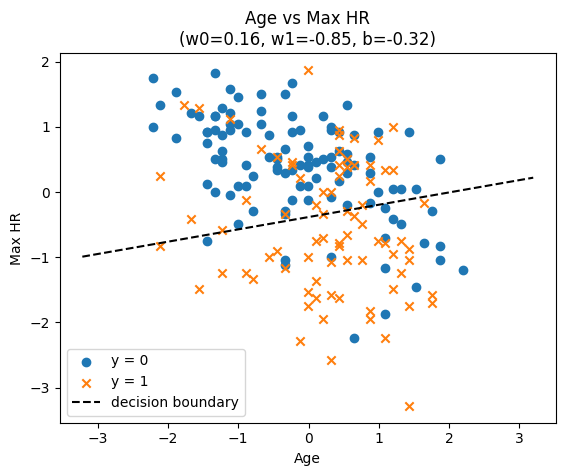

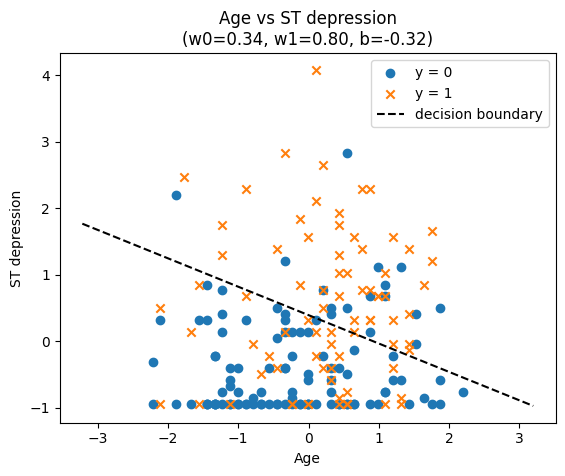

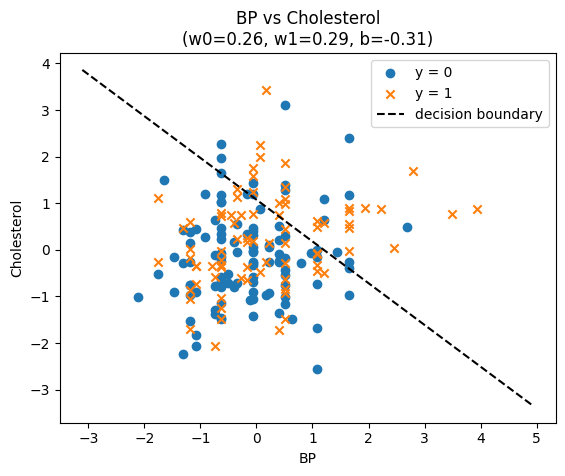

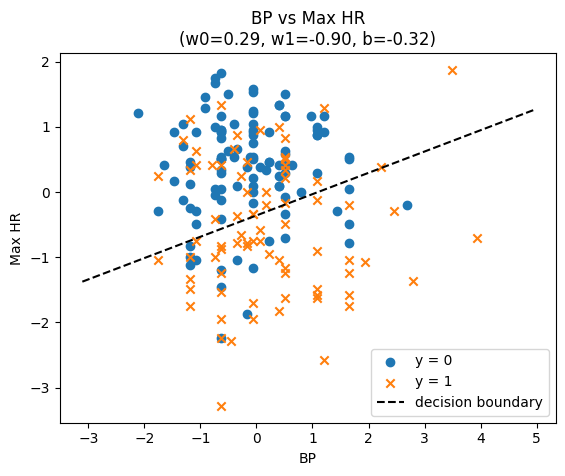

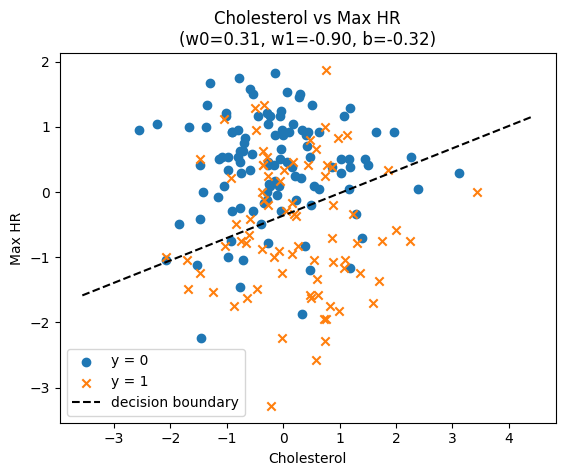

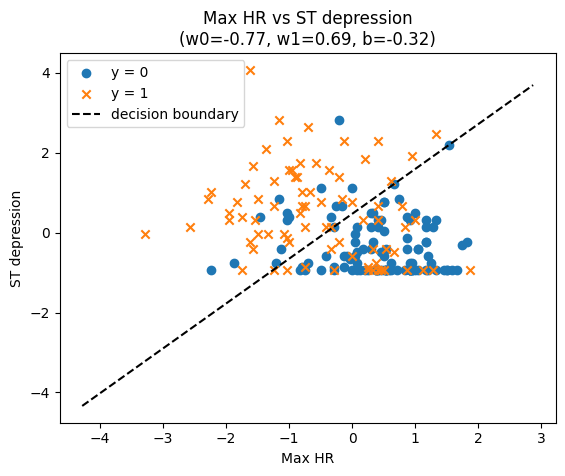

In [106]:
for feat1, feat2 in feature_pairs: 
    X_2d = train[[feat1, feat2]].values
    y_2d = train["Heart_Disease"].values
    
    X_mean = np.mean(X_2d, axis=0)
    X_std = np.std(X_2d, axis=0) + 1e-8  # Avoid division by zero
    X_norm = (X_2d - X_mean) / X_std
    
    w_2d = np.zeros(2)
    b_2d = 0
    w_2d, b_2d, _ = gradient_descent(X_norm, y_2d, w_2d, b_2d, 0.01, 1000)
    
    title = f"{feat1} vs {feat2}\n(w0={w_2d[0]:.2f}, w1={w_2d[1]:.2f}, b={b_2d:.2f})"
    plot_linear_data_with_boundary(w_2d, b_2d, X_norm, y_2d, title, feat1, feat2)

The plots shows that none of the feature pairs can clearly separate heart disease patients from healthy ones. In all plots, the decision boundary line has both circles (no disease) and X's (disease) on both sides; they all overlap heavily. Even the "best" pairs like Age vs ST Depression and Max HR vs ST Depression can't draw a clean line between the classes. This means heart disease can't be predicted well using just two features at a time; the data is too mixed up.